In [4]:
import numpy as np
from math import *
from scipy import integrate
from cyfuncs import zhao_func
from exceptions import Exception, ValueError, OverflowError, ZeroDivisionError

In this notebook I integrate the DM squared density (to obtain the *J-factor*) using the same strategy as in CLUMPY:  
I split the integral into three regions:  
- the "front" part of the Halo, zone 1   
- the "rear" part of the Halo, zone 2  
- the inner cusp/core, zone 3  

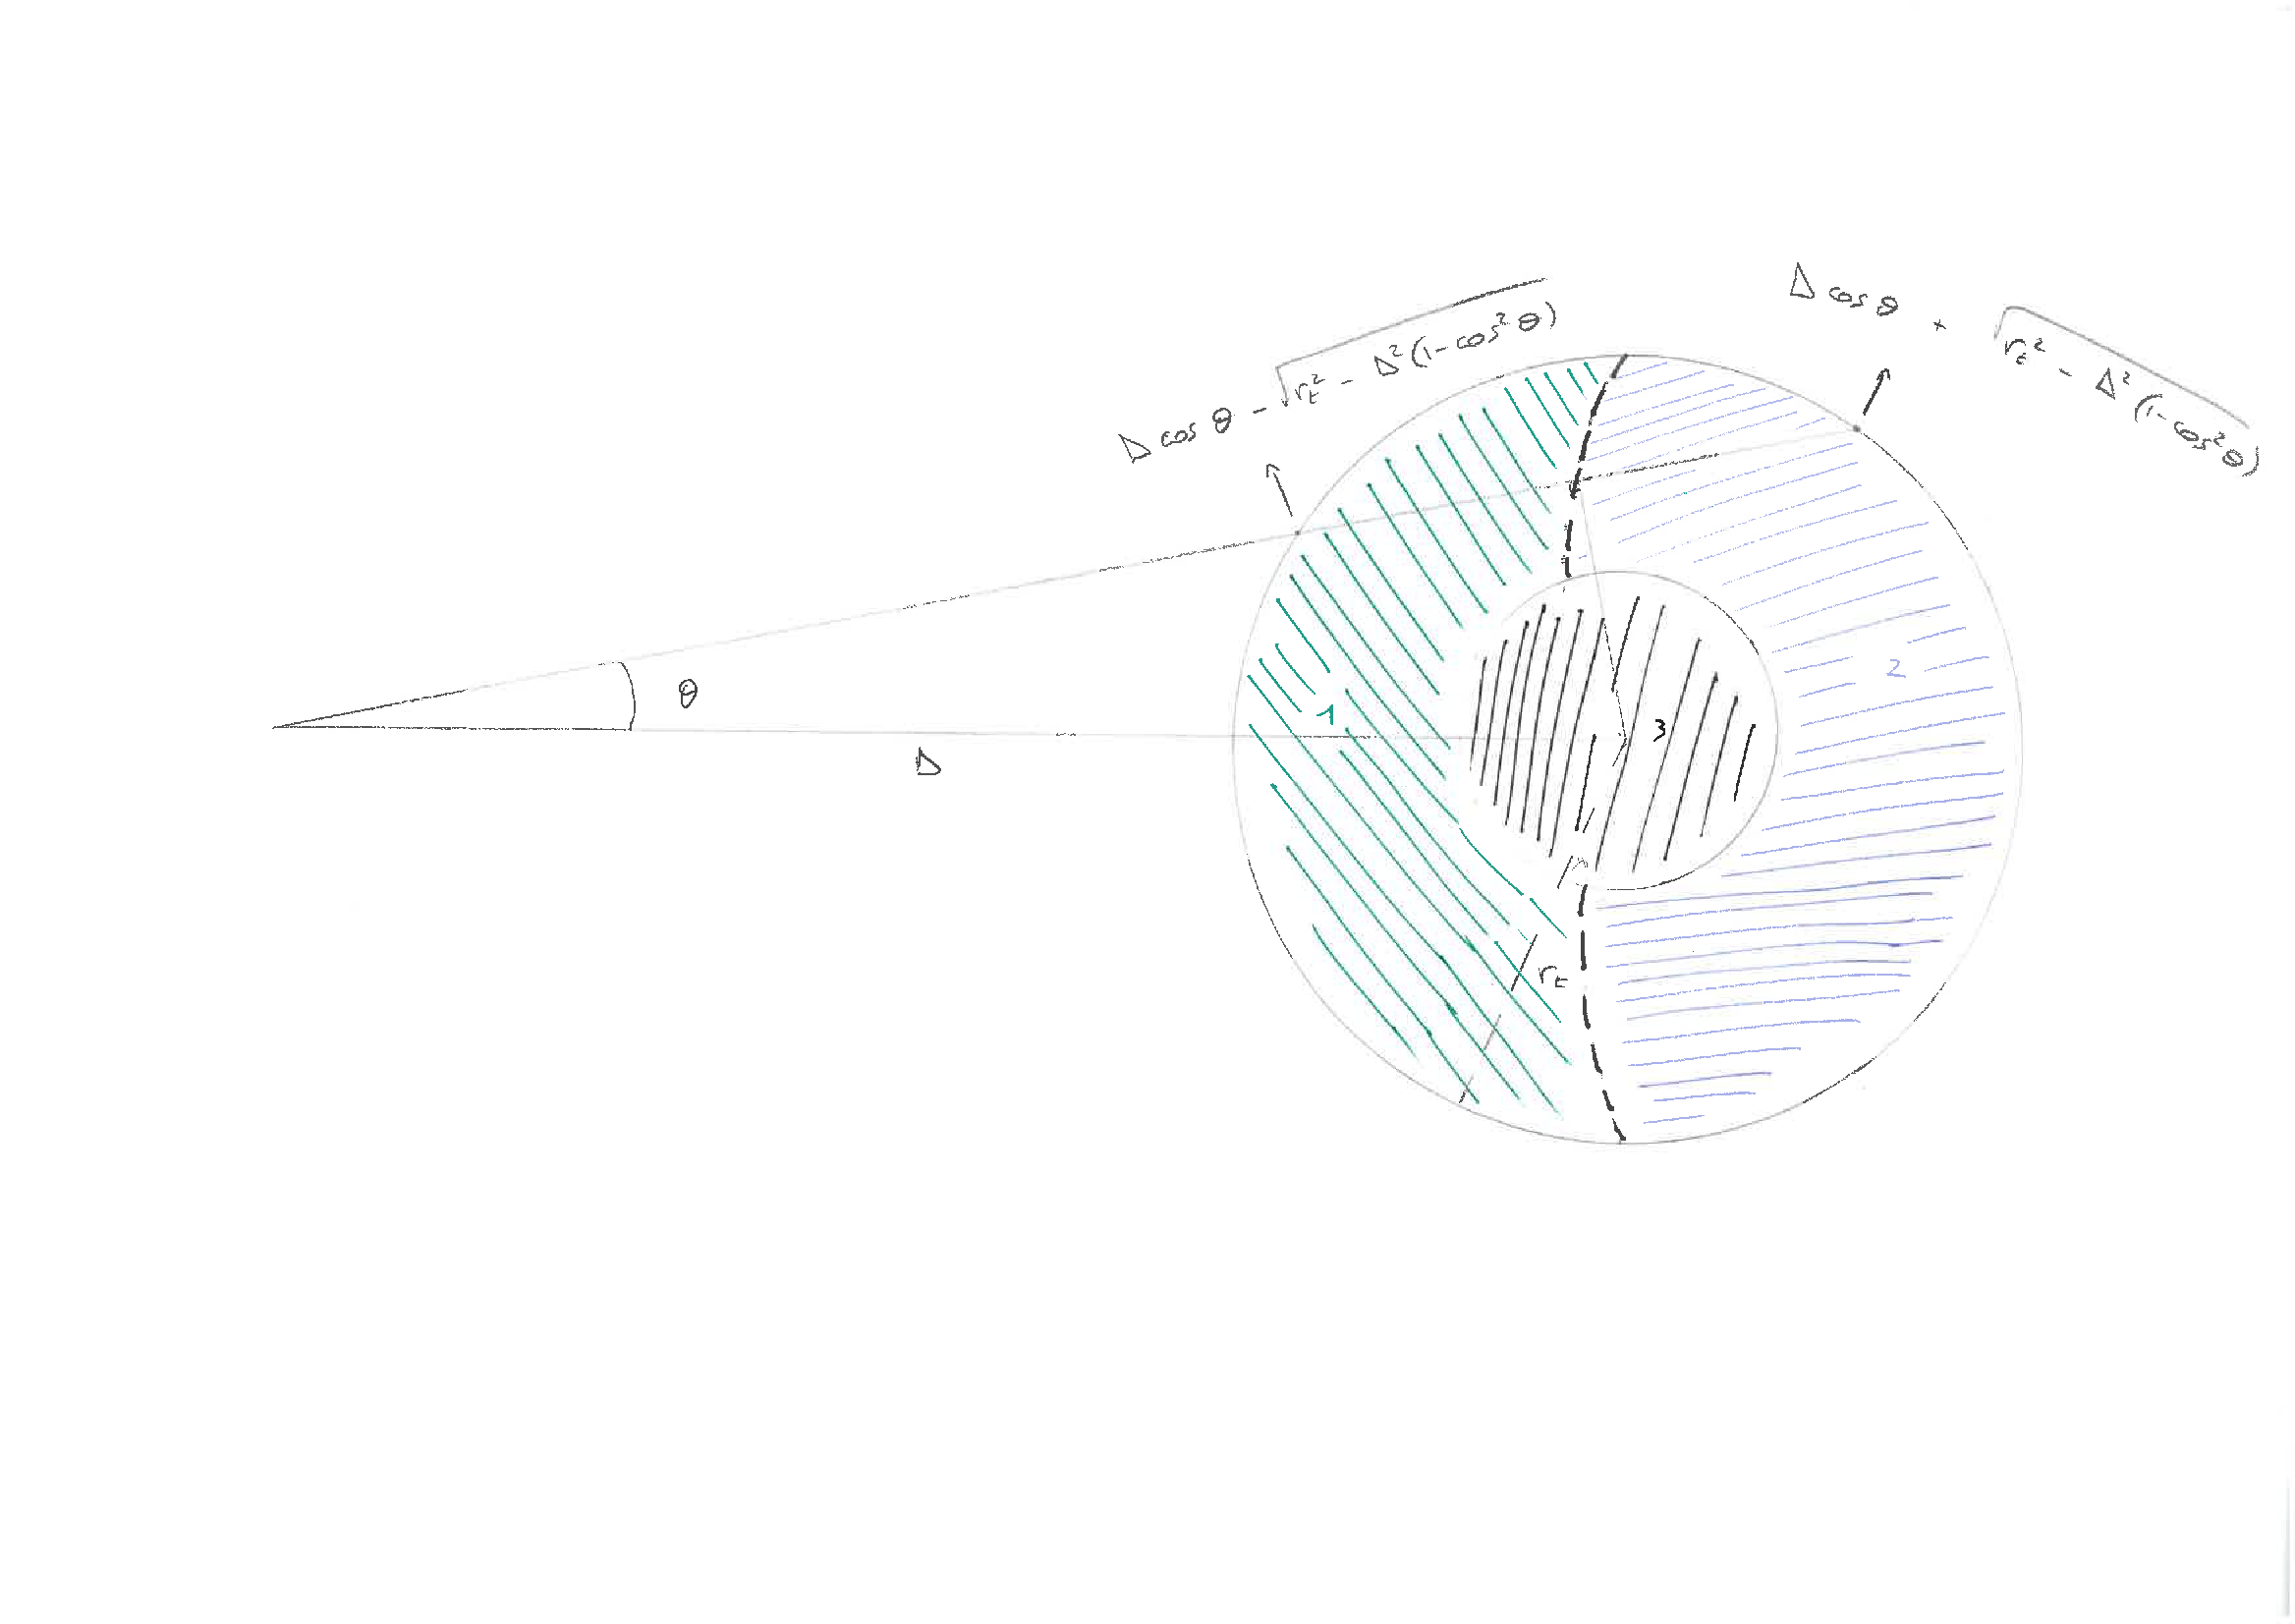

In [2]:
from IPython.display import Image
Image("SKM_C30817040512000.png", width=800, height=500)

In [5]:
# physical parameters as in Alex's simulations (except rt)
rh = 0.04
D = 40.
r0 = 0.35
rho0 = 7.55e7
rt = 2.#np.inf
rc = 0.01
theta = 2*rh/D
rhosat = 1e19

theta = 0.5
Dprime = D/r0
rtprime = rt/r0
rcprime = rc/r0
ymin = cos( np.radians(theta) )
Amin = cos( np.radians( atan( rc/D ) ) )

a = 1.
b = 3.
c = 1.

These functions implement the generalised NFW (as in the module `cyfuncs.pyx`)

In [6]:
# in this cell I compare to the calculation performed on ASTROJPY

from profiles import build_profile, build_kernel
dm_true = build_profile('NFW')
dwarf_props = {'D':D, 'theta':theta, 'rt':np.inf, 'with_errs':True}
dm_true.r0 = 0.35
print dm_true.Jreduced(**dwarf_props)

(2.3275349991944863e-05, 1.0942592518591704e-07)


In [8]:
# here I use the same definition of the density function rho
# as in CLUMPY: returning a fixed value for small r

a = 1.
b = 3.
c = 1.

rc = r0*(rho0/rhosat)**(1/c)

def density(x, a=a, b=b, c=c):
    if c>1e-5:
        if x > rc/r0:
            return zhao_func(x, a, b, c)
        else:
            return rhosat
    else:
        return zhao_func(x, a, b, 0.)

def radius(z, y):
    try:
        return sqrt( z*z + Dprime*Dprime * (1 - y*y ) )
    except (OverflowError, ZeroDivisionError, ValueError):
        return np.nan

def integrand(x, y, ymin, rt, D):
    try:
        return 2*density( radius(x, y) )**2
    except (OverflowError, ZeroDivisionError):
        return np.nan

# with the modified version of the density function
# I don't need to split the integration range

def lim_l(y, ymin, rt, D):
    l_min = 0#- sqrt( rt*rt - D*D * (1. - y*y) )
    l_max = + sqrt( rt*rt - D*D * (1. - y*y) )
    return [l_min, l_max]

def lim_y(ymin, rt, D):
    return [ymin, 1.]

In [9]:
I = integrate.nquad(integrand, ranges=[lim_l, lim_y], args=(ymin, np.inf, Dprime), \
                        opts=[{'limit':1000, 'epsabs':1.e-8, 'epsrel':1.e-8},\
                              {'limit':1000, 'epsabs':1.e-8, 'epsrel':1.e-8}])

print I, I[0]>I[1]

(4.6550699983889685e-05, 2.188518503718341e-07) True
